In [48]:
import gensim
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import PorterStemmer
import nltk
import time

In [49]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = PorterStemmer()

def load_data(path):
    files = open(path, 'r', encoding='utf-8')
    raw_docs = files.readlines()
    docs = []
    flag = 0
    temp = ""
    for doc in raw_docs:
        if doc[:2] == '.I':
            flag = 0
            docs.append(temp)
            temp = ""
        elif doc[:2] == '.W':
            flag = 1
        elif flag == 1:
            content = doc.replace('.', '').replace("''", '').replace('\n', '').lower()
            content = gensim.utils.simple_preprocess(content)
            content = [" "+non_stopword for non_stopword in content if non_stopword not in stopwords]
            content = [stemmer.stem(word) for word in content]
            temp +=  " ".join(content)

    docs = np.asarray(docs[1:])
    return docs

In [3]:
docs = load_data('cran.all.1400')
docs = [doc.split() for doc in docs]

In [4]:
queries = load_data('cran.qry')
queries = [query.split() for query in queries]

In [5]:
dictionary = gensim.corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

In [6]:
tfidf = gensim.models.TfidfModel(corpus, smartirs='npu')
corpus_tfidf = tfidf[corpus]

In [53]:
corpus_tfidf[0][:10]

[(0, 0.046833881000219256),
 (1, 0.07619211165561775),
 (2, 0.04203839939052154),
 (3, 0.059104440634731775),
 (4, 0.07256489535439657),
 (5, 0.016646463716567104),
 (6, 0.037581807606420346),
 (7, 0.0680584678312247),
 (8, 0.07534255875593336),
 (9, 0.05707967436585535)]

In [7]:
lsi = gensim.models.LsiModel(corpus_tfidf, num_topics=280)
index = gensim.similarities.MatrixSimilarity(lsi[corpus_tfidf]) #Cosine Similarity

In [33]:
lsi[corpus_tfidf][0][:10]

[(0, 0.16800342273043603),
 (1, -0.015095275558128278),
 (2, 0.09843736164586996),
 (3, 0.14586960249330438),
 (4, -0.04071016321040013),
 (5, -0.03785180177562449),
 (6, -0.02584938097604107),
 (7, -0.0037506982612062444),
 (8, -0.022297153848275623),
 (9, 0.05669339240658127)]

In [46]:
def Calculate_AP(retrieval, query):
    precision = 0
    precision_list = []
    recall_list = []

    for i in range(len(retrieval)):
        if retrieval[i] in query:
            precision += 1
            precision_list.append(float(precision)/(i+1))
            recall_list.append(float(precision)/len(query))

    temp = 0
    for i in range(len(precision_list)-1,-1,-1):
        if temp >= precision_list[i]:
            precision_list[i] = temp
        elif temp < precision_list[i]:
            temp = precision_list[i]
    
    precision_list_11 = []
    for i in range(11):
        for j in range(len(recall_list)):
            if recall_list[j] >= (i/10):
                precision_list_11.append(max(precision_list[j:]))
                break
    if len(precision_list_11) < 11:
        precision_list_11 += [0]*(11-len(precision_list_11))

    return sum(precision_list_11)/len(precision_list_11)

def mAP(rank, qrel):
    mAP = []
    for i in range(len(rank)):
        ap = Calculate_AP(rank[i], qrel[i])
        mAP.append(ap)
    return np.mean(np.array(mAP))

def cosine_similarity(corpus_lsi,query_lsi):
    matrix_term = []
    for idx in corpus_lsi:
        term_vec = [value[1] for value in idx]
        if term_vec == []:
            matrix_term.append(np.array([0.000000001]*len(corpus_lsi[0])))
        else:
            matrix_term.append(np.array(term_vec))
    matrix_term = np.array(matrix_term)
    query_term = np.array([value[1] for value in query_lsi])
    
    return np.dot(matrix_term, query_term) / (np.linalg.norm(matrix_term) * np.linalg.norm(query_term))

In [47]:
fqrel = open('cranqrel', 'r', encoding='utf-8')
qrel = []
for f in fqrel.readlines():
    qrel.append(f.split()[:2])
    
groundtruth = [[] for i in range(225)]

for i in qrel:
    idx = int(i[0]) - 1
    truth = int(i[1]) - 1
    groundtruth[idx].append(truth)

In [10]:
import time

def ranking(_lsi, _index, queries):
    all_rank = []
    for query in queries:
        new_vec = dictionary.doc2bow(query)
        vec_tfidf = tfidf[new_vec]
        vec_lsi = _lsi[vec_tfidf]
        sims = _index[vec_lsi]
        # sims = cosine_similarity(lsi[corpus_tfidf], vec_lsi)
        rank = np.argsort(sims)[::-1]
        all_rank.append(rank)

    return all_rank

In [11]:
start_time = time.time()
all_rank = ranking(lsi, index, queries)
print('Executed tf-idf time: {}'.format(time.time() - start_time))
print(f'Kết quả MAP: {mAP(all_rank, groundtruth)}')

Executed tf-idf time: 0.694598913192749
Kết quả MAP: 0.43729703604940967


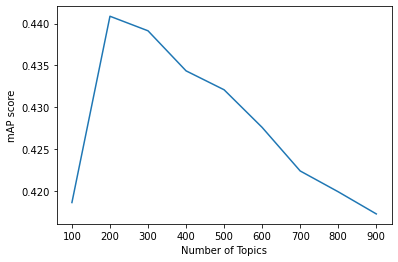

In [16]:
map_value = []
for num_topic in range(100,1000, 100):
    model = gensim.models.LsiModel(corpus_tfidf, num_topics=num_topic)
    indexing = gensim.similarities.MatrixSimilarity(model[corpus_tfidf])
    all_rank = ranking(model, indexing, queries)
    map_value.append(mAP(all_rank, groundtruth))

x=range(100,1000,100)
plt.plot(x, map_value)
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

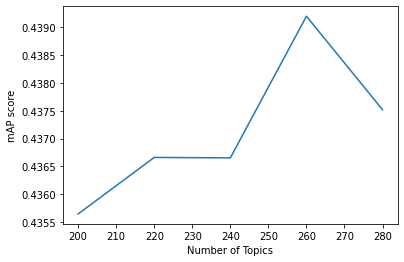

In [15]:
map_value = []
for num_topic in range(200,300, 20):
    model = gensim.models.LsiModel(corpus_tfidf, num_topics=num_topic)
    indexing = gensim.similarities.MatrixSimilarity(model[corpus_tfidf])
    all_rank = ranking(model, indexing, queries)
    map_value.append(mAP(all_rank, groundtruth))

x=range(200,300,20)
plt.plot(x, map_value)
plt.xlabel('Number of Topics')
plt.ylabel('mAP score')
plt.show()

In [17]:
np.max(map_value)

0.4408683778722717